The following example shows LSTM training on data that are labeled using the naive methods. The example shows evaluation using the mean (mu) threshold on 1 SD pair dataset only.

In [9]:
'''
Train Naive Methods (mu, mu+1sigma, mu+2sigma, mu+3sigma, EE, ORCE, IF, LOF, KMeans)
'''

import warnings
warnings.filterwarnings("ignore")

import os, math, random
import pandas as pd
import numpy as np
import random
import glob, sys
from sklearn.model_selection import train_test_split
from sklearn import *
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

sys.path.append('../')
from utils import get_full_path

In [10]:
# Set threshold file name
# thresholds_file = "Threshold-atl.csv" # default
# thresholds_file = "label_thresholds_atl.csv"
thresholds_file = "Threshold-ripe.csv"

In [11]:
# db_dir = get_full_path('data_28')
db_dir = get_full_path('ripe')

snuba_split_set_dir = get_full_path('snuba', 'input_snuba')
threshold_dir = get_full_path('snuba', 'data', 'ripe')
output_dir = get_full_path('snuba', 'results', 'ripe')

from snuba.program_synthesis.heuristic_generator import HeuristicGenerator
from snuba.program_synthesis.synthesizer import Synthesizer
from snuba.program_synthesis.verifier import Verifier
from snuba.lstm.lstm import *

np.random.seed(42)

In [12]:
os.chdir(db_dir)
datasets = glob.glob('*.csv')
datasets_sorted = sorted(datasets)
print(datasets_sorted)

# Choose dataset_00
client1 = datasets_sorted[0]

['out_000.csv', 'out_001.csv', 'out_002.csv', 'out_003.csv', 'out_004.csv', 'out_005.csv', 'out_006.csv', 'out_007.csv', 'out_008.csv', 'out_009.csv', 'out_010.csv', 'out_011.csv', 'out_012.csv', 'out_013.csv', 'out_014.csv', 'out_015.csv', 'out_016.csv', 'out_017.csv', 'out_018.csv', 'out_019.csv', 'out_020.csv', 'out_021.csv', 'out_022.csv', 'out_023.csv', 'out_024.csv', 'out_025.csv', 'out_026.csv', 'out_027.csv', 'out_028.csv', 'out_029.csv', 'out_030.csv', 'out_031.csv', 'out_032.csv', 'out_033.csv', 'out_034.csv', 'out_035.csv', 'out_036.csv', 'out_037.csv', 'out_038.csv', 'out_039.csv', 'out_040.csv', 'out_041.csv', 'out_042.csv', 'out_043.csv', 'out_044.csv', 'out_045.csv', 'out_046.csv', 'out_047.csv', 'out_048.csv', 'out_049.csv', 'out_050.csv', 'out_051.csv', 'out_052.csv', 'out_053.csv', 'out_054.csv', 'out_055.csv', 'out_056.csv', 'out_057.csv', 'out_058.csv', 'out_059.csv', 'out_060.csv', 'out_061.csv', 'out_062.csv', 'out_063.csv', 'out_064.csv', 'out_065.csv', 'out_066.

In [13]:
def load_data(client):
    input_dir = snuba_split_set_dir+'/'+str(client[:-4])
    os.chdir(input_dir)
    train_original = pd.read_csv(glob.glob('train_original_*')[0])
    val_original = pd.read_csv(glob.glob('val_original_*')[0])
    test_original = pd.read_csv(glob.glob('test_original_*')[0])
    
    val_ground = np.load(glob.glob('val_ground_*')[0])
    test_ground = np.load(glob.glob('test_ground_*')[0])
    
    return train_original, val_original, test_original, val_ground, test_ground

In [14]:
# Take RTT data for train, val, and test set
train_original, val_original, test_original, val_ground, test_ground = load_data(client1)

train_data = train_original['rtt']
val_data = val_original['rtt']
test_data = test_original['rtt']

IndexError: list index out of range

In [8]:
os.chdir(db_dir + '/')
clients = sorted(glob.glob('*.csv'))

# Specify client_number, in this case 0 since we are using dataset_00
client_number = 0
client1 = clients[client_number]
# client1

In [9]:
# Get the mu threshold value
naive_thresholds = []
os.chdir(db_dir + '/')

print('==============================================================')
print('    Client ' + client1[:-4]) 
print('==============================================================')
df = pd.read_csv(client1)

os.chdir(threshold_dir + '/')

df_threshold = pd.read_csv(thresholds_file)

# Specify which naive method. In this example: mean (mu)
# If desired naive method is ORCE, put:
# naive_threshold = df_threshold['ORCE'][client_number]
naive_threshold = df_threshold['Mean'][client_number]
print('Mean threshold: ', naive_threshold)

# result_dir = f"{output_dir}/{client1[:-4]}/" # /snuba/results/dataset_xx/ ??
result_dir = f"{output_dir}/" # /snuba/results/

# Change to results dir
os.chdir(result_dir)

    Client dataset_00
Mean threshold:  26.781


In [10]:
# Create naive labels for train set

def label_naive_data(x, naive_threshold):
    if x >= naive_threshold:
        y = -1
    else:
        y = 1
    return y

In [11]:
val_naive_label = val_ground
test_naive_label = test_ground

df_naive = train_original['rtt'].to_frame()
df_naive['label'] = df_naive['rtt'].apply(lambda x: label_naive_data(x, naive_threshold))

train_naive_label = df_naive['label']

In [14]:
df_naive

rtt  label
0     1650.000      0
1       24.981      1
2      928.000      0
3      199.519      0
4     2300.000      0
...        ...    ...
3329    30.643      0
3330    28.231      0
3331    31.302      0
3332  3188.000      0
3333  3111.000      0

[3334 rows x 2 columns]

In [12]:
# Validate

def validate(client1):
    
    bs = 32
    n = 20
    num_cells = 64
    lr = 0.001
    l2_reg = 0.3
    dropout_val = 0.2
    
    y_pred = lstm_simple(train_data, train_naive_label, val_data, val_naive_label, client=client1[:-4], heuristic='mean',\
                            bs=bs, n=n, num_cells=num_cells, lr=lr, l2_reg=l2_reg, dropout_val=dropout_val)

    predictions = np.round(y_pred)


    naive_val_acc = np.sum(predictions == val_naive_label)/float(np.shape(val_naive_label)[0])

    naive_val_f1 = metrics.f1_score(val_naive_label, predictions, average='micro')
    naive_val_pr = metrics.precision_score(val_naive_label, predictions, average='micro')
    naive_val_re = metrics.recall_score(val_naive_label, predictions, average='micro')



    print ('=================================================================')
    print ('    Naive Mean Validation Results')
    print ('    Client ' + client1[:-4])
    print ('=================================================================')

    print ('Best Validation Accuracy: ', naive_val_acc)
    print ('Validation F1 Score: ', naive_val_f1)
    print ('Validation Best Pr: ', naive_val_pr)
    print ('Validation Best Re: ', naive_val_re)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 3334 samples, validate on 834 samples
Epoch 1/20
3334/3334 [==============================] - 10s 3ms/step - loss: 17.7889 - accuracy: 0.7373 - val_loss: 15.7694 - val_accuracy: 0.8945
Epoch 2/20
3334/3334 [==============================] - 9s 3ms/step - loss: 14.1637 - accuracy: 0.9061 - val_loss: 12.4654 - val_accuracy: 0.9532
Epoch 3/20
3334/3334 [==============================] - 9s 3ms/step - loss: 11.1879 - accuracy: 0.9262 - val_loss: 9.7321 - val_accuracy: 0.9652
Epoch 4/20
3334/3334 [==============================] - 9s 3ms/step - loss: 8.7401 - accuracy: 0.9178 - val_loss: 7.5144 - val_accuracy: 0.9652
Epoch 5/20
3334/3334 [==============================] - 9s 3ms/step - loss: 6.7293 - accuracy: 0.9373 - val_loss: 5.7445 - val_accuracy: 0.9532
Epoch 6/20
3334/3334 [=============================

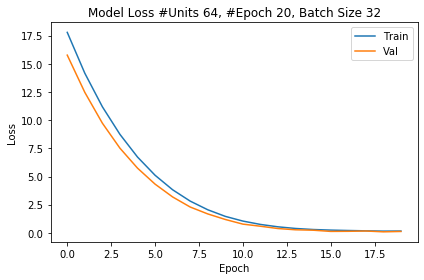

Accuracy: 95.32%
    Naive Mean Validation Results
    Client dataset_00
Best Validation Accuracy:  0.9532374100719424
Validation F1 Score:  0.9532374100719424
Validation Best Pr:  0.9532374100719424
Validation Best Re:  0.9532374100719424


In [13]:
validate(client1)

In [15]:
def test(client1):
    
    # Note: hyperparameters could be different for different datasets
    bs = 32 # batch size
    n = 20  # num epochs?
    num_cells = 64
    lr = 0.001 # learning rate
    l2_reg = 0.3
    dropout_val = 0.2
    early_stopping_epoch = n

    y_pred = lstm_simple(train_data, train_naive_label, test_data, test_naive_label, client=client1[:-4], heuristic='mean',\
                                bs=bs, n=early_stopping_epoch, \
                                num_cells=num_cells, lr=lr, l2_reg=l2_reg, dropout_val=dropout_val)

    predictions = np.round(y_pred)

    naive_test_acc = np.sum(predictions == test_naive_label)/float(np.shape(test_naive_label)[0])
    print ('=================================================================')
    print ('    Naive Mean Test Results')
    print ('    Client ' + client1[:-4])
    print ('=================================================================')
    print ('Test Accuracy: ', naive_test_acc)
    naive_test_f1 = metrics.f1_score(test_naive_label, predictions, average='micro')
    print ('Test F1 Score: ', naive_test_f1)
    print ('Test Precision: ', metrics.precision_score(test_naive_label, predictions, average='micro'))
    print ('Test Recall: ', metrics.recall_score(test_naive_label, predictions, average='micro'))
    
    print(f"Num entries: {len(predictions)}")
    
    return naive_test_f1

Train on 3334 samples, validate on 500 samples
Epoch 1/20
3334/3334 [==============================] - 5s 1ms/step - loss: 17.7591 - accuracy: 0.7942 - val_loss: 15.6467 - val_accuracy: 0.9980
Epoch 2/20
3334/3334 [==============================] - 4s 1ms/step - loss: 14.1604 - accuracy: 0.9025 - val_loss: 12.4287 - val_accuracy: 0.9660
Epoch 3/20
3334/3334 [==============================] - 4s 1ms/step - loss: 11.1916 - accuracy: 0.9241 - val_loss: 9.7149 - val_accuracy: 0.9660
Epoch 4/20
3334/3334 [==============================] - 4s 1ms/step - loss: 8.7458 - accuracy: 0.9256 - val_loss: 7.5447 - val_accuracy: 0.9560
Epoch 5/20
3334/3334 [==============================] - 4s 1ms/step - loss: 6.7387 - accuracy: 0.9295 - val_loss: 5.7177 - val_accuracy: 0.9660
Epoch 6/20
3334/3334 [==============================] - 4s 1ms/step - loss: 5.1176 - accuracy: 0.9307 - val_loss: 4.3083 - val_accuracy: 0.9560
Epoch 7/20
3334/3334 [==============================] - 4s 1ms/step - loss: 3.8300 -

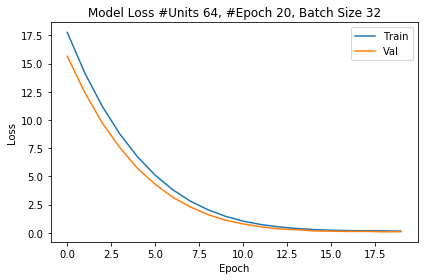

Accuracy: 95.60%
    Naive Mean Test Results
    Client dataset_00
Test Accuracy:  0.956
Test F1 Score:  0.956
Test Precision:  0.956
Test Recall:  0.956
Num entries: 500
Training duration: 89.72237


In [16]:
from timeit import default_timer as timer

start = timer() # get current time for measurement analysis
test(client1)
end_val = timer()

duration = round(end_val - start, 5)

print(f"Training duration: {duration}")